In [1]:
import os
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics, ensemble
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore') 

#Loading data
#import all the data
train_df = pd.read_csv("/Users/jiaxinye/database/walmart_data/train.csv")
test_df = pd.read_csv("/Users/jiaxinye/database/walmart_data/test.csv")
features = pd.read_csv("/Users/jiaxinye/database/walmart_data/features.csv")
stores = pd.read_csv("/Users/jiaxinye/database/walmart_data/stores.csv")

In [2]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
#merge two datarames features and stores, the store will be our key
features_store = features.merge(stores, how='inner', on='Store')

In [4]:
# Merge two dataframes named 'features_store' and 'train'
merged_train_df = train_df.merge(features_store, 
                       how='inner',
                       on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [5]:
merged_train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [6]:
# Merge two dataframes named 'features_store' and 'test'
merged_test_df = test_df.merge(features_store, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
merged_test_df.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [7]:
#check whether have duplicate value or not
duplicates = len(merged_train_df[merged_train_df.duplicated(subset=['Store',"Dept",'Date'])])
duplicates

0

In [8]:
#change date to dateframe
merged_train_df.Date = pd.to_datetime(merged_train_df.Date)
merged_train_df['Year'] = merged_train_df['Date'].dt.year
merged_train_df['WeekOfYear'] = merged_train_df['Date'].dt.week

merged_train_df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
Year                     int64
WeekOfYear               int64
dtype: object

In [9]:
merged_test_df.Date = pd.to_datetime(merged_test_df.Date)
merged_test_df['Year'] = merged_test_df['Date'].dt.year
merged_test_df['WeekOfYear'] = merged_test_df['Date'].dt.week

In [10]:
merged_test_df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
Year                     int64
WeekOfYear               int64
dtype: object

In [11]:
#relationship between weekly_sales and  markdown
corr_matrix = merged_train_df.corr()
corr_matrix.Weekly_Sales.sort_values(ascending=False)

Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.090362
MarkDown1       0.085251
MarkDown3       0.060385
MarkDown4       0.045414
WeekOfYear      0.027673
MarkDown2       0.024130
IsHoliday       0.012774
Fuel_Price     -0.000120
Temperature    -0.002312
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64

<Figure size 432x288 with 0 Axes>

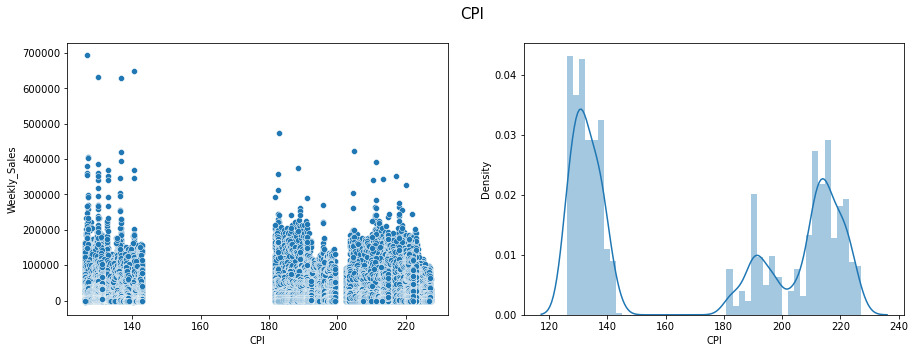

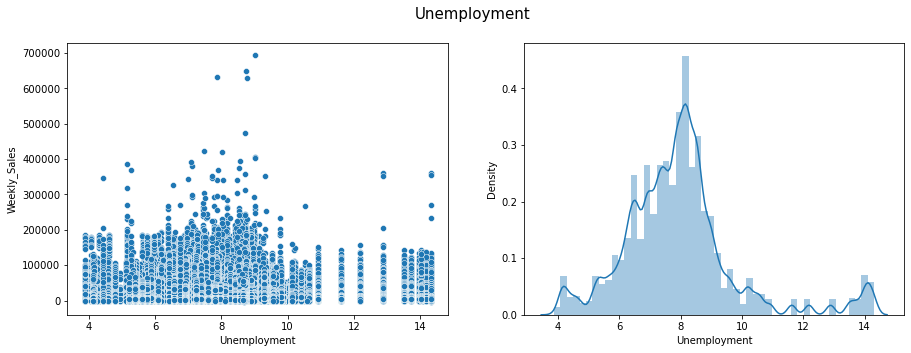

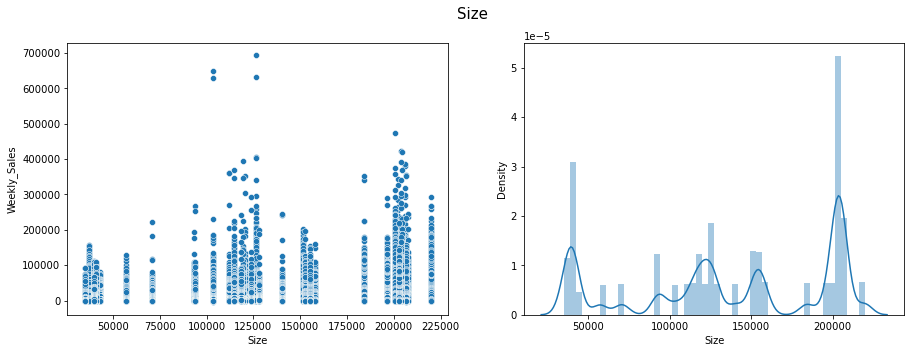

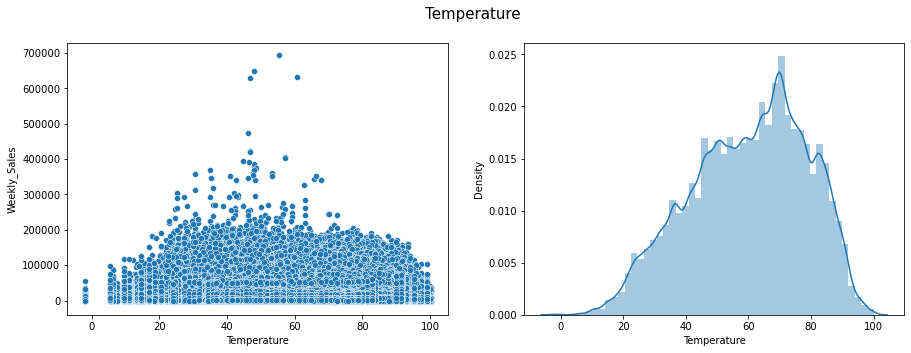

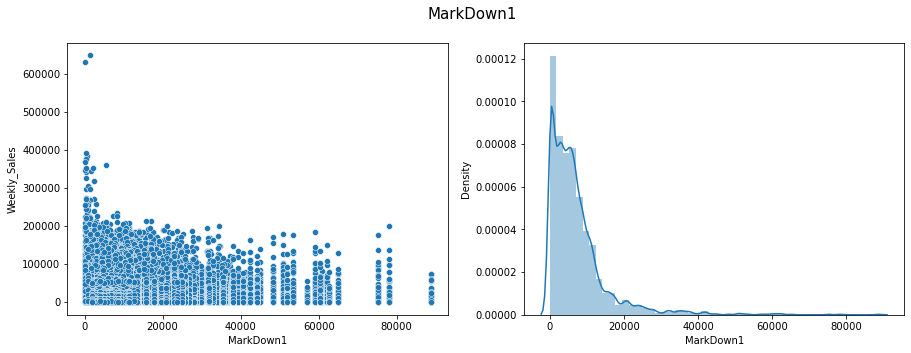

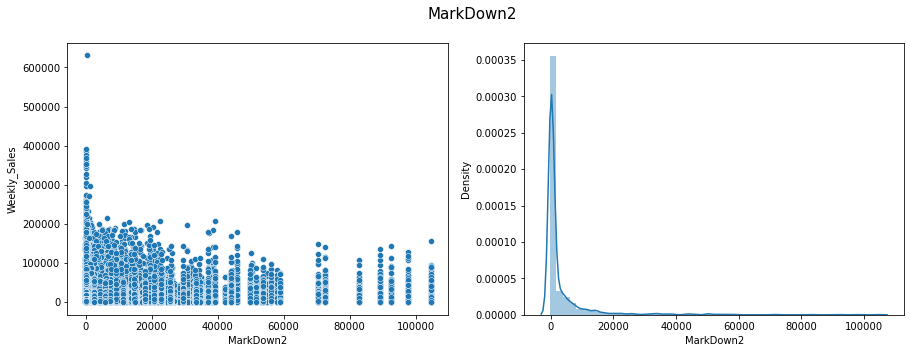

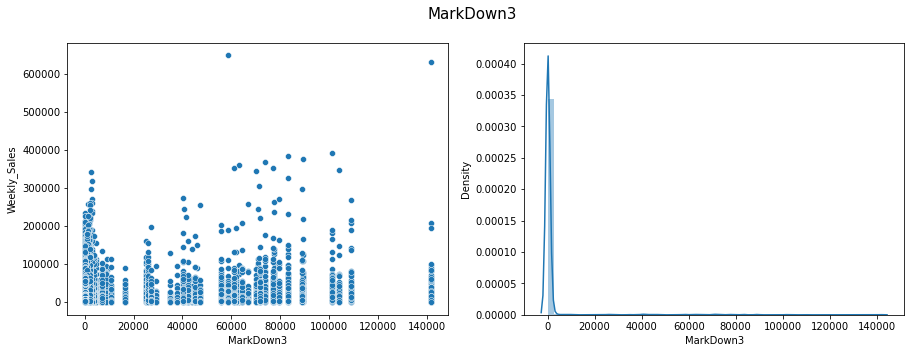

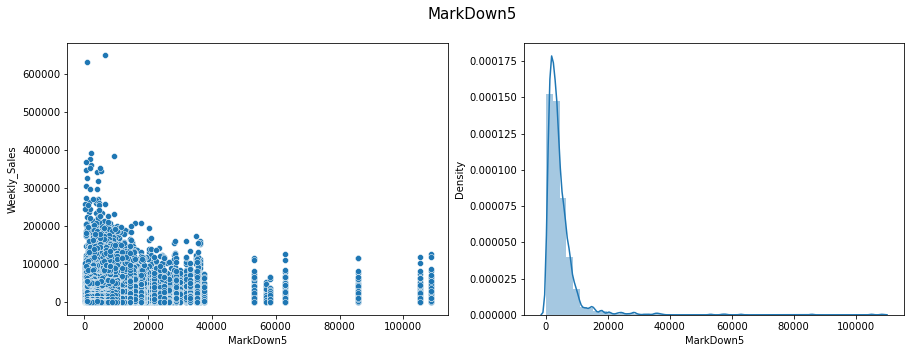

In [12]:
### for the numerical variable CPI,employment,fuel_price lets plot kde and scatter plot
fig = plt.figure()
def kde_scatter(data,x,y,title):
     '''Funcation plots KDE plot and Scatter plot as subplots '''
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))
     fig.suptitle(title,fontsize=15)
     sns.scatterplot(x=data[x],y=data[y],ax=axes[0])
     sns.distplot(data[x], kde=True,ax=axes[1])
     plt.show()
## plotting KDE and scatter for Numerical Variables
kde_scatter(merged_train_df,'CPI','Weekly_Sales',"CPI")
kde_scatter(merged_train_df,'Unemployment','Weekly_Sales',"Unemployment")
kde_scatter(merged_train_df,'Size','Weekly_Sales','Size')
kde_scatter(merged_train_df,'Temperature','Weekly_Sales','Temperature')
kde_scatter(merged_train_df,'MarkDown1','Weekly_Sales','MarkDown1')
kde_scatter(merged_train_df,'MarkDown2','Weekly_Sales','MarkDown2')
kde_scatter(merged_train_df,'MarkDown3','Weekly_Sales','MarkDown3')
kde_scatter(merged_train_df,'MarkDown5','Weekly_Sales','MarkDown5')

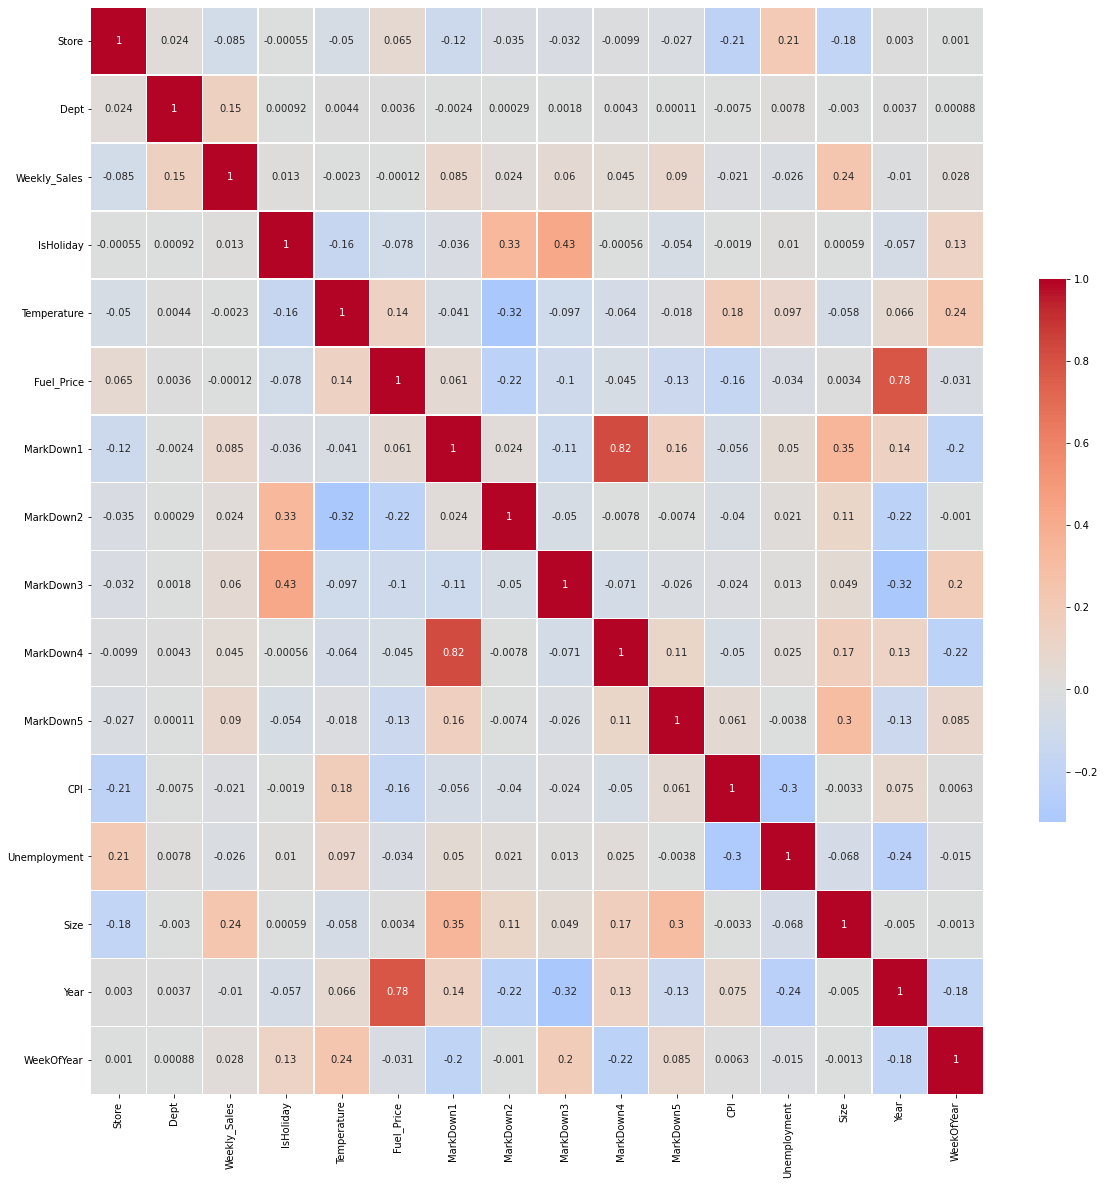

In [13]:
#using Pearson Correlation to see the correlation between variables
#0: no correlation at all
#0-0.3: weak correlation
#0.3-0.7: moderate correlaton
#0.7-1: strong correlation
plt.figure(figsize = (20,20))
corr = merged_train_df.corr()
sns.heatmap (corr, cmap='coolwarm',center=0, annot=True, linewidths=.5, cbar_kws={"shrink": .5});

In [14]:
### fuel price and year are highly correlated -> drop fuel price
### markdown 1 and markdown 4 are corelated
### size has strong corelation with weekly_sale
### temperatrue has weak coorealtion with sales
### due to higher missing values in the markdown columns, the distribution is right skewed

In [15]:
# mean sales over year (Univariate Analysis)
## let’s craete two date features here week,year for analysis


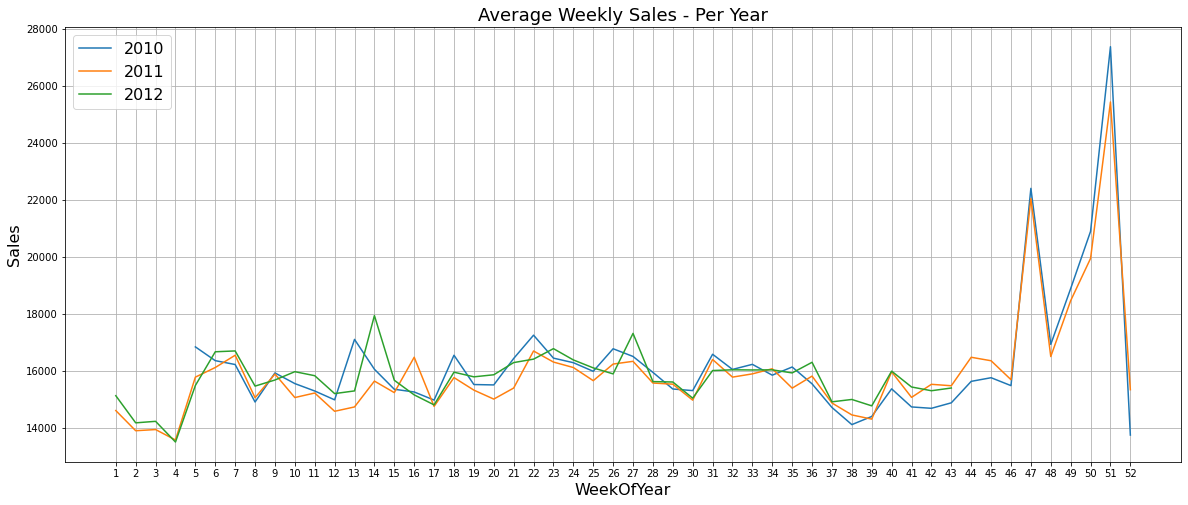

In [16]:
weekly_sales_2010 = merged_train_df[merged_train_df.Year==2010]['Weekly_Sales'].groupby(merged_train_df['WeekOfYear']).mean()
weekly_sales_2011 = merged_train_df[merged_train_df.Year==2011]['Weekly_Sales'].groupby(merged_train_df['WeekOfYear']).mean()
weekly_sales_2012 = merged_train_df[merged_train_df.Year==2012]['Weekly_Sales'].groupby(merged_train_df['WeekOfYear']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('WeekOfYear', fontsize=16)
plt.show()

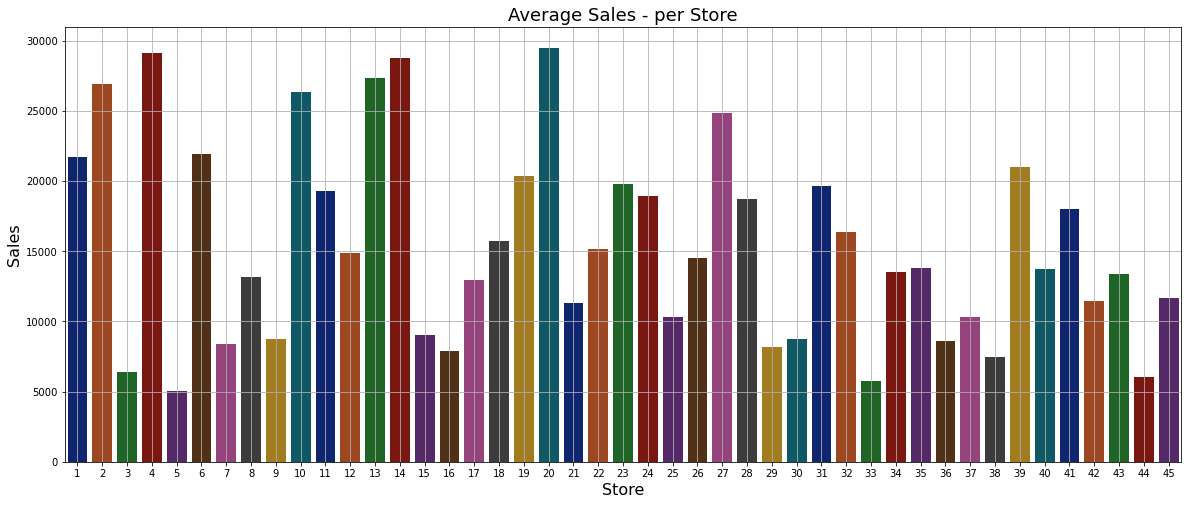

In [17]:
weekly_sales = merged_train_df['Weekly_Sales'].groupby(merged_train_df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

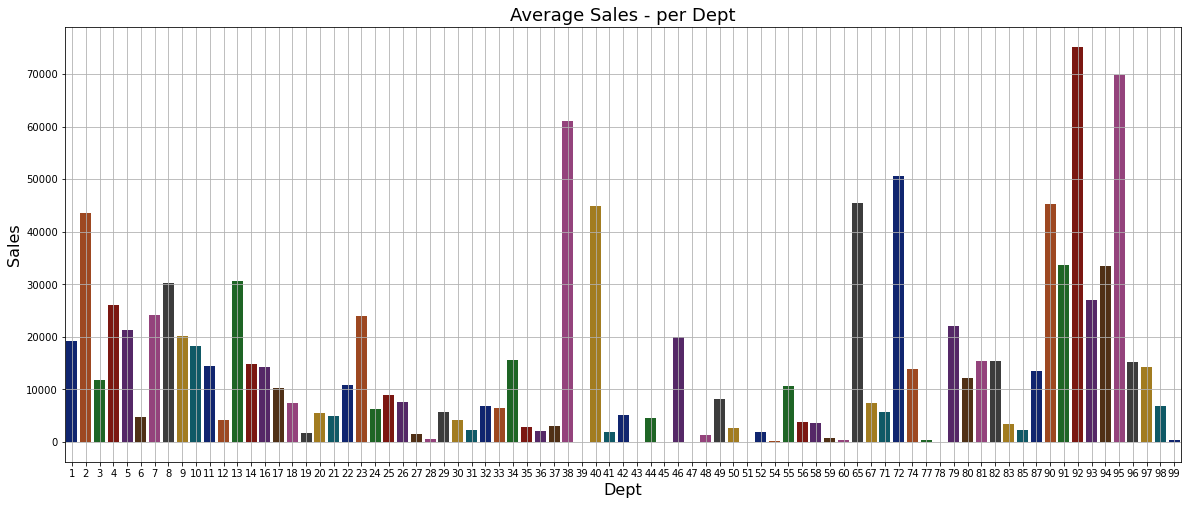

In [18]:
weekly_sales = merged_train_df['Weekly_Sales'].groupby(merged_train_df['Dept']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

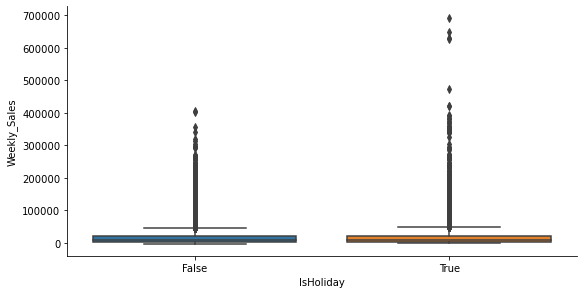

In [19]:
IsHoliday_g = sns.catplot(x='IsHoliday', y= 'Weekly_Sales',
                          data=merged_train_df, kind="box",
                 height=4, aspect=2);

In [20]:
###points on holidays are greater than non holidays

# prepocessing data

In [21]:
# check missing values
merged_train_df.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
WeekOfYear           0
dtype: int64

In [22]:
#fill in the missing value with mean
merged_train_df.fillna(merged_train_df.mean(),inplace = True)

In [23]:
merged_train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
WeekOfYear      0
dtype: int64

In [24]:
merged_test_df.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
WeekOfYear          0
dtype: int64

In [25]:
#fill in the missing value with mean
merged_test_df.fillna(merged_test_df.mean(),inplace = True)
# fill in unemployment rate min value and cpi with max value
merged_test_df['Unemployment']=merged_test_df['Unemployment'].fillna(merged_test_df['Unemployment'].min())
merged_test_df['CPI']=merged_test_df['CPI'].fillna(merged_test_df['CPI'].max())

In [26]:
merged_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Temperature   115064 non-null  float64       
 5   Fuel_Price    115064 non-null  float64       
 6   MarkDown1     115064 non-null  float64       
 7   MarkDown2     115064 non-null  float64       
 8   MarkDown3     115064 non-null  float64       
 9   MarkDown4     115064 non-null  float64       
 10  MarkDown5     115064 non-null  float64       
 11  CPI           115064 non-null  float64       
 12  Unemployment  115064 non-null  float64       
 13  Type          115064 non-null  object        
 14  Size          115064 non-null  int64         
 15  Year          115

In [27]:
merged_train_df = pd.get_dummies(merged_train_df, columns=["Type"])
merged_test_df = pd.get_dummies(merged_test_df, columns=["Type"])


In [28]:
merged_train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,WeekOfYear,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,42.31,2.572,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.096358,8.106,151315,2010,5,1,0,0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.242170,8.106,151315,2010,6,1,0,0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.289143,8.106,151315,2010,7,1,0,0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.319643,8.106,151315,2010,8,1,0,0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.350143,8.106,151315,2010,9,1,0,0


In [29]:
#Encoding categorical data
merged_train_df['IsHoliday'] = merged_train_df['IsHoliday'].apply(lambda x: 5 if x == True else 0)
merged_test_df['IsHoliday'] = merged_test_df['IsHoliday'].apply(lambda x: 5 if x == True else 0)

In [30]:
merged_train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,WeekOfYear,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,42.31,2.572,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.096358,8.106,151315,2010,5,1,0,0
1,1,1,2010-02-12,46039.49,5,38.51,2.548,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.242170,8.106,151315,2010,6,1,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.289143,8.106,151315,2010,7,1,0,0
3,1,1,2010-02-26,19403.54,0,46.63,2.561,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.319643,8.106,151315,2010,8,1,0,0
4,1,1,2010-03-05,21827.90,0,46.50,2.625,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.350143,8.106,151315,2010,9,1,0,0


In [ ]:
#Feature selection
#drop date and fuel_price columns

In [31]:
id = merged_test_df["Store"].astype(str)+"_"+merged_test_df["Dept"].astype(str)+"_"+merged_test_df["Date"].astype(str)
test_data = merged_test_df.drop([ "Date", "Fuel_Price"], axis=1)

In [32]:
train_data = merged_train_df.drop(["Date","Fuel_Price"], axis=1)

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
 4   Temperature   421570 non-null  float64
 5   MarkDown1     421570 non-null  float64
 6   MarkDown2     421570 non-null  float64
 7   MarkDown3     421570 non-null  float64
 8   MarkDown4     421570 non-null  float64
 9   MarkDown5     421570 non-null  float64
 10  CPI           421570 non-null  float64
 11  Unemployment  421570 non-null  float64
 12  Size          421570 non-null  int64  
 13  Year          421570 non-null  int64  
 14  WeekOfYear    421570 non-null  int64  
 15  Type_A        421570 non-null  uint8  
 16  Type_B        421570 non-null  uint8  
 17  Type_C        421570 non-null  uint8  
dtypes: f

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   IsHoliday     115064 non-null  int64  
 3   Temperature   115064 non-null  float64
 4   MarkDown1     115064 non-null  float64
 5   MarkDown2     115064 non-null  float64
 6   MarkDown3     115064 non-null  float64
 7   MarkDown4     115064 non-null  float64
 8   MarkDown5     115064 non-null  float64
 9   CPI           115064 non-null  float64
 10  Unemployment  115064 non-null  float64
 11  Size          115064 non-null  int64  
 12  Year          115064 non-null  int64  
 13  WeekOfYear    115064 non-null  int64  
 14  Type_A        115064 non-null  uint8  
 15  Type_B        115064 non-null  uint8  
 16  Type_C        115064 non-null  uint8  
dtypes: float64(8), int64(6), uint8(3)
memory usage: 

In [35]:
import time
import os
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone

class Tester():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.scores = {}
        self.cache = {} # added a simple cache to speed things up

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model
        
    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}
    
    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = clone(self.models[m_name])
        
        if not sample_len: 
            sample = self.datasets[df_name]
        else: sample = self.datasets[df_name].sample(sample_len)
            
        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]

        #metric weights
        weights = X["IsHoliday"]
        clf.fit(X, Y)
        Y_pred = clf.predict(X)
        s = mean_absolute_error(Y, Y_pred, sample_weight=weights)
        self.cache[(m_name, df_name, sample_len, cv)] = s

        return s

    def runTests(self, sample_len=97056, cv=3):
        # Test the added model on all the added datasets
        for m_name in self.models:
            for df_name in self.datasets:
                # print('Testing %s' % str((m_name, df_name)), end='')
                start = time.time()

                score = self.testModelWithDataset(m_name, df_name, sample_len, cv)
                self.scores[(m_name, df_name)] = score
                
                end = time.time()
                
                # print(' -- %0.2fs ' % (end - start))

        print('--- Top 10 Results ---')
        # We're gonna have to change the grading system here
        for score in sorted(self.scores.items(), key=lambda x: x[1])[:10]:
            # score = int(score[1])
            print(score)

    def obtian_result(self, X_test):
        clf = self.models[sorted(self.scores.items(), key=lambda x: x[1])[0][0]]
        Y_pred = clf.predict(X_test)
        return Y_pred

In [36]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor

# test object
tester = Tester('Weekly_Sales')

# add dataset
tester.addDataset('all_markdown', train_data)


# add model
knn_reg = KNeighborsRegressor(n_neighbors=10)
tree_reg = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
rf_reg = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
svr_reg = SVR(kernel='rbf', gamma='auto')
mlp_reg = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
gbrt_reg = GradientBoostingRegressor(max_depth=8, warm_start=True)
tester.addModel('KNeighborsRegressor', knn_reg)
tester.addModel('ExtraTreesRegressor', tree_reg)
tester.addModel('RandomForestRegressor', rf_reg)
tester.addModel('SVR', svr_reg)
tester.addModel('MLPRegressor', mlp_reg)
tester.addModel('GradientBoostingRegressor', gbrt_reg)

# test
tester.runTests()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished


Iteration 1, loss = 246898517.48003754
Iteration 2, loss = 245243537.06046262
Iteration 3, loss = 244872002.68854129
Iteration 4, loss = 244849949.66742855
Iteration 5, loss = 244712257.16794637
Iteration 6, loss = 244610405.00088054
Iteration 7, loss = 244506639.54856893
Iteration 8, loss = 244443739.96131840
Iteration 9, loss = 244419298.56151047
Iteration 10, loss = 244281112.50314313
Iteration 11, loss = 244130203.40765584
Iteration 12, loss = 244128721.63718128
Iteration 13, loss = 244063029.40324616
Iteration 14, loss = 244025945.46784231
Iteration 15, loss = 243855000.70026556
Iteration 16, loss = 243864633.40961477
Iteration 17, loss = 243782296.74143362
Iteration 18, loss = 243718161.10345143
Iteration 19, loss = 243561540.22013569
Iteration 20, loss = 243498490.61538801
Iteration 21, loss = 243432087.61532053
Iteration 22, loss = 243452534.11529240
Iteration 23, loss = 243254932.30746928
Iteration 24, loss = 243261069.54948881
Iteration 25, loss = 243117443.23697454
Iteration

In [37]:
X = train_data.drop(["Weekly_Sales"], axis=1)
Y = train_data["Weekly_Sales"]

tree_reg.fit(X, Y)
Y_pred = tree_reg.predict(test_data)
submission = pd.DataFrame({
        "Id": id,
        "Weekly_Sales": pd.DataFrame(Y_pred)[0]
    })
id

submission.to_csv('submission1.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.8s finished


In [39]:
sample = pd.read_csv("/Users/jiaxinye/database/submission1.csv")

In [40]:
sample.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,31560.0374
1,1_1_2012-11-09,23776.8582
2,1_1_2012-11-16,24286.8863
3,1_1_2012-11-23,22082.3330
4,1_1_2012-11-30,25552.3634


In [41]:
sample.tail()

,Id,Weekly_Sales
115059,45_98_2013-06-28,552.6430
115060,45_98_2013-07-05,580.0187
115061,45_98_2013-07-12,548.7387
115062,45_98_2013-07-19,549.9821
115063,45_98_2013-07-26,531.3181
